## Run options
Set `recalc` to True to force recalculating all results, otherwise, load the saved results from file.

Choose `easy` or `hard` to specify which dataset to test over.

In [30]:
recalc = True
difficulty = "easy"  # or "hard"

SIM_EVALS = 10     # PAPER VALUE: 100
tuning_iters = 10  # PAPER VALUE: 100
TUNENET_EPOCHS = 10 # PAPER VALUE: 200

In [31]:
import numpy as np
import os
from tune.definitions import ROOT_DIR, OUTPUT_DIR
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import importlib
from tune.utils import save_files, load_files, get_torch_device
from tune.train_tunenet_gt import INPUT_DIM, OUT_DIM, BATCH_SIZE
import tune.train_tunenet_gt
from tune.model_tunenet import TuneNet
import torch

%matplotlib inline
%load_ext jupyternotify

output_path = os.path.join(ROOT_DIR, OUTPUT_DIR)
print(ROOT_DIR)

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify
/home/wang/github/tune-net-release


In [32]:
# What kind of sim are we going to run?
from tune.ball_sim import BallSim
from tune.dataset_tunenet import DatasetTuneNet
importlib.reload(tune.ball_sim)
importlib.reload(tune.dataset_tunenet)

SimType = BallSim

if difficulty == "easy":
    prefix, test_loader, graph_title =  \
        "ball_gt", DatasetTuneNet.get_data_loader("tune", "ground_truth", "val", BATCH_SIZE), "GT Easy"
elif difficulty == "hard":
    prefix, test_loader, graph_title = \
       "ball_gt_hard", DatasetTuneNet.get_data_loader("tune_hard", "ground_truth", "val", BATCH_SIZE), "GT Hard"
else:
    raise Exception("I don't know what kind of difficulty you're going for (you told me '{}')".format(difficulty))

Using Torch device: cuda:0
this dataset exists in /home/wang/github/tune-net-release/datasets/tune/val
dataset loaded from /home/wang/github/tune-net-release/datasets/tune/val with 100 elements


## Load the dataset

In [33]:
import torch
targets_loaded = []
with torch.no_grad():
    with SimType() as sim:
        for batch_idx, batch_data in enumerate(test_loader):
            zeta_batch = batch_data[0]
            s_batch = batch_data[1]
            print("max:")
            print(torch.max(zeta_batch[:, 1, 0]))
            print("min:")
            print(torch.min(zeta_batch[:, 1, 0]))
            print("mean:")
            print(torch.mean(torch.abs(zeta_batch[:, 1, 0] - zeta_batch[:, 0, 0])))
            targets_loaded.append(zeta_batch[:, 1, 0].detach().cpu().float())
            print("========")
print(targets_loaded)

max:
tensor(0.6982, device='cuda:0', dtype=torch.float64)
min:
tensor(0.3058, device='cuda:0', dtype=torch.float64)
mean:
tensor(0.1350, device='cuda:0', dtype=torch.float64)
max:
tensor(0.6998, device='cuda:0', dtype=torch.float64)
min:
tensor(0.3022, device='cuda:0', dtype=torch.float64)
mean:
tensor(0.1353, device='cuda:0', dtype=torch.float64)
[tensor([0.4030, 0.4319, 0.5903, 0.5236, 0.4444, 0.3223, 0.5336, 0.3853, 0.4647,
        0.3714, 0.5048, 0.4138, 0.6175, 0.5353, 0.5991, 0.3058, 0.4537, 0.4505,
        0.6954, 0.6551, 0.6850, 0.3766, 0.4607, 0.4997, 0.5200, 0.3583, 0.4887,
        0.3919, 0.3842, 0.5712, 0.6118, 0.4985, 0.5668, 0.3682, 0.4887, 0.4170,
        0.3585, 0.6982, 0.6027, 0.3847, 0.6029, 0.6694, 0.6692, 0.4265, 0.3157,
        0.6490, 0.5017, 0.6357, 0.3320, 0.5252]), tensor([0.3471, 0.3332, 0.4956, 0.4076, 0.3522, 0.3022, 0.3345, 0.5960, 0.6601,
        0.5433, 0.6598, 0.4975, 0.6469, 0.3078, 0.6576, 0.4128, 0.3264, 0.6550,
        0.4281, 0.5275, 0.5748, 0.3276,

# Use Test Mean as Estimate

In [34]:
targets = torch.cat(targets_loaded, dim=0)
print("overall target mean:")
mean = np.mean(targets.numpy())
print(mean)
constant_diffs = torch.abs(torch.tensor(mean).expand((len(targets))) - targets)
print(np.mean(constant_diffs.cpu().detach().numpy()))

overall target mean:
0.49128616
0.10124391


# TuneNet Estimate

In [35]:
model_name = "tunenet_gt"
outnames = [model_name + "_history.pkl", "each_" + model_name + "_error.pkl"]

In [36]:
# %%notify -m "finished testing TuneNet"
if recalc:
    importlib.reload(tune.train_tunenet_gt)
    
    model = TuneNet(INPUT_DIM, OUT_DIM).to(get_torch_device())
    model.load_state_dict(torch.load(os.path.join(output_path, model_name + "_{}.pth".format(TUNENET_EPOCHS))))
    with SimType() as sim:
        _, _, tunenet_history, each_tunenet_error = \
            tune.train_tunenet_gt.test(1, model, sim, test_loader,
                                       tuning_iterations=tuning_iters,
                                       display_graphs=False)

    tunenet_history = tunenet_history.cpu().detach().numpy()

    save_files(prefix, [tunenet_history, each_tunenet_error], outnames)

Using Torch device: cuda:0
creating logdir /home/wang/github/tune-net-release/saves/tensorboard_2019-11-16T21:05:47.860262+00:00
Using Torch device: cuda:0
Creating TuneNet with input sizes 400 and 400, hidden size 32
Using Torch device: cuda:0
Testing over test...
dataset size is 100
mae of zeta_list: 0.2002
mse of zeta_list: 0.052708


(100, 11)
0.42477998


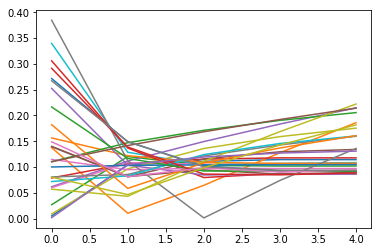

In [37]:
tunenet_history, each_tunenet_error = load_files(prefix, outnames)
fig, ax = plt.subplots()
print(each_tunenet_error.shape)
# ax.plot(np.mean(each_tunenet_error, axis=0, keepdims=False))
ax.plot(np.swapaxes(each_tunenet_error[1:30, :5], 0, 1))
print(np.amax(each_tunenet_error))

# Direct Neural Estimate

In [38]:
model_name = "tunenet_gt_direct"
outnames = [model_name + "_history.pkl", "each_" + model_name + "_error.pkl"]

In [39]:
# %%notify -m "finished testing TuneNet Direct"
if recalc:
    model = TuneNet(INPUT_DIM, OUT_DIM, degenerate=True).to(get_torch_device())
    model.load_state_dict(torch.load(os.path.join(output_path, model_name + "_{}.pth".format(TUNENET_EPOCHS))))
    with SimType() as sim:
        _, _, tunenet_direct_history, each_tunenet_direct_error = \
            tune.train_tunenet_gt.test(1, model, sim, test_loader,
                                       tuning_iterations=1,
                                       display_graphs=False,
                                       incremental=False)

    tunenet_direct_history = tunenet_direct_history.cpu().detach().numpy()
    save_files(prefix, [tunenet_direct_history, each_tunenet_direct_error],
               outnames)
print(tunenet_direct_history)

Using Torch device: cuda:0
Creating [Degenerate] TuneNet with input sizes 400 and 400, hidden size 32
Using Torch device: cuda:0
Testing over test...
dataset size is 100
mae of zeta_list: 0.0583
mse of zeta_list: 0.003916
[[0.51228726 0.3145534 ]
 [0.5279718  0.36413231]
 [0.34364197 0.41442287]
 [0.57656664 0.46986762]
 [0.6683589  0.3327479 ]
 [0.4227648  0.3767675 ]
 [0.39359987 0.39426285]
 [0.5313271  0.366804  ]
 [0.5020555  0.54276955]
 [0.39774373 0.3079235 ]
 [0.6038731  0.39787942]
 [0.32983655 0.6211845 ]
 [0.50369567 0.5817419 ]
 [0.559932   0.5988386 ]
 [0.31324506 0.47108534]
 [0.35952437 0.31033093]
 [0.67518765 0.4832836 ]
 [0.67641836 0.40650928]
 [0.55394363 0.40898108]
 [0.3460261  0.539276  ]
 [0.46859196 0.3227761 ]
 [0.30187201 0.36783922]
 [0.4111916  0.5876242 ]
 [0.6600954  0.4320118 ]
 [0.52453464 0.34714037]
 [0.5747997  0.46733347]
 [0.6683164  0.56294334]
 [0.5149863  0.5224557 ]
 [0.40680373 0.5215248 ]
 [0.620176   0.35267276]
 [0.50492555 0.31369603]
 [0

(100, 11)
0.3844787


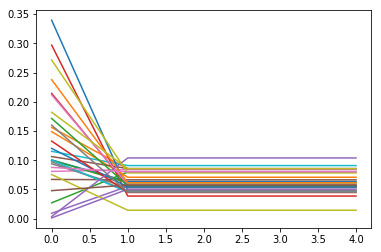

In [40]:
tunenet_direct_history, each_tunenet_direct_error = load_files(prefix, outnames)
# Tile the direct (single-iteration) tunenet result so its first dimension matches the other results
tunenet_direct_history = np.pad(tunenet_direct_history,
                                ((0, 0), (0, tuning_iters-tunenet_direct_history.shape[1]+1)),
                                mode="edge")
each_tunenet_direct_error = np.pad(each_tunenet_direct_error,
                                   ((0, 0), (0, tuning_iters-each_tunenet_direct_error.shape[1]+1)),
                                   mode="edge")
fig, ax = plt.subplots()
print(each_tunenet_direct_error.shape)
# ax.plot(np.mean(each_tunenet_error, axis=0, keepdims=False))
ax.plot(np.swapaxes(each_tunenet_direct_error[1:30, :5], 0, 1))
print(np.amax(each_tunenet_direct_error))

# CMA-ES Estimate

In [49]:
# %%notify -m "finished CMA-ES"
if recalc:
    from tune.cma import do_cma, do_cma_over_dataset
    from tune.utils import exec_sim
    import torch
    importlib.reload(tune.cma)

    with SimType() as sim:
        cma_evals, cma_estimates, cma_targets = do_cma_over_dataset(test_loader, sim, maxfevals=SIM_EVALS, popsize=10)

    save_files(prefix, [cma_evals, cma_estimates, cma_targets],
               ["cma_evals.pkl", "cma_estimates.pkl", "cma_targets.pkl"])

newstyle
creating logdir /home/wang/github/tune-net-release/saves/cmaes_2019-11-16T21:29:39.023524+00:00
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 2 (seed=1037749, Sat Nov 16 16:29:39 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 5.863599844768443e+00 1.0e+00 1.19e-01  1e-01  1e-01 0:00.9
    2     20 2.437137775935379e+00 1.3e+00 1.45e-01  1e-01  2e-01 0:01.8
creating logdir /home/wang/github/tune-net-release/saves/cmaes_2019-11-16T21:31:52.121762+00:00
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 2 (seed=1002446, Sat Nov 16 16:31:52 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.959963203205842e+00 1.0e+00 9.89e-02  7e-02  1e-01 0:00.5
    2     20 1.492037314061931e+00 1.7e+00 7.62e-02  4e-02  9e-02 0:00.9
creating logdir /home/wang/github/tune-net-release/saves/cmaes_2019-11-16T21:31:53.228523+00:00
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 2 (seed=1052490, Sat Nov 16 16:31:

KeyboardInterrupt: 

In [42]:
cma_evals, cma_estimates, cma_targets = load_files(prefix,
           ["cma_evals.pkl", "cma_estimates.pkl", "cma_targets.pkl"])

# Greedy Entropy Search Estimate

In [43]:
# %%notify -m "finished Greedy Entropy Search"
if recalc:
    from tune.entsearch import entsearch_over_dataset
    from tune.utils import get_timestamp
    importlib.reload(tune.entsearch)

    print(get_timestamp())
    # range of possible parameter values
    big_theta = np.linspace(np.min(targets.numpy()), np.max(targets.numpy()), 50)
    epsilon = 0.001
    print(big_theta)
    # max number of sims
    k_max = SIM_EVALS
    # population size
    n = 200

    print("Performing entropy search...")
    entsearch_P_history, entsearch_estimates, entsearch_targets = None, None, None
    with SimType() as sim:
        entsearch_P_history, entsearch_estimates, entsearch_targets = \
            entsearch_over_dataset(test_loader, sim, big_theta, epsilon, k_max, n)
    print("Entropy search complete.")
    print(get_timestamp())

    save_files(prefix, [entsearch_P_history, entsearch_estimates, entsearch_targets],
               ["entsearch_P_history.pkl", "entsearch_estimates.pkl", "entsearch_targets.pkl"])

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy
2019-11-16T21:06:38.945445+00:00
[0.30219683 0.31031078 0.31842472 0.32653867 0.33465261 0.34276656
 0.3508805  0.35899445 0.3671084  0.37522234 0.38333629 0.39145023
 0.39956418 0.40767812 0.41579207 0.42390601 0.43201996 0.44013391
 0.44824785 0.4563618  0.46447574 0.47258969 0.48070363 0.48881758
 0.49693153 0.50504547 0.51315942 0.52127336 0.52938731 0.53750125
 0.5456152  0.55372914 0.56184309 0.56995704 0.57807098 0.58618493
 0.59429887 0.60241282 0.61052676 0.61864071 0.62675466 0.6348686
 0.64298255 0.65109649 0.65921044 0.66732438 0.67543833 0.68355227
 0.69166622 0.69978017]
Performing entropy search...
entropy search, dataset idx 0
entropy search, dataset idx 1
entropy search, dataset idx 2
entropy search, dataset idx 3
entropy search, dataset i

 /home/wang/anaconda3/envs/tunenet/lib/python3.6/site-packages/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square


In [44]:
entsearch_P_history, entsearch_estimates, entsearch_targets = load_files(prefix,
    ["entsearch_P_history.pkl", "entsearch_estimates.pkl", "entsearch_targets.pkl"])

# Munge results

In [45]:
# print(cma_estimates)
# print(type(cma_estimates))
# print(type(cma_estimates[0,0]))

# calculate the error for each tuning instance wrt that instance's target parameter value
each_cma_error = np.abs(cma_targets[:, 0:1] - cma_estimates[:, :, 0])
each_entsearch_error = np.abs(entsearch_targets[:, np.newaxis] - entsearch_estimates[:, :])
# calculate mean error
mean_cma_error = np.mean(each_cma_error, axis=0)
mean_tunenet_error = np.mean(each_tunenet_error, axis=0, keepdims=False)
mean_tunenet_direct_error = np.mean(each_tunenet_direct_error, axis=0, keepdims=False)
mean_entsearch_error = np.mean(each_entsearch_error, axis=0, keepdims=False)

# need two points to define a line for plotting, so duplicate the result
each_constant_error = constant_diffs.unsqueeze(1).repeat([1, 2]).numpy()
# also need x-values to plot
constant_x = [0, SIM_EVALS]

# find average across all runs
mean_constant_error = np.mean(each_constant_error, axis=0, keepdims=False)

# Plot

N = [1, 5, 10, 100]
minimum value over the first N iterations
1
1
1
1
Mean                 & 0.1012 & 0.1012 & 0.1012 & 0.1012
1
5
10
10
EntSearch            & 0.1452 & 0.0730 & 0.0555 & 0.0555
1
1
1
3
CMA-ES               & 0.0647 & 0.0647 & 0.0647 & 0.0328
1
5
10
10
Direct Prediction    & 0.0583 & 0.0583 & 0.0583 & 0.0583
1
5
10
10
TuneNet              & 0.0870 & 0.1579 & 0.2002 & 0.2002


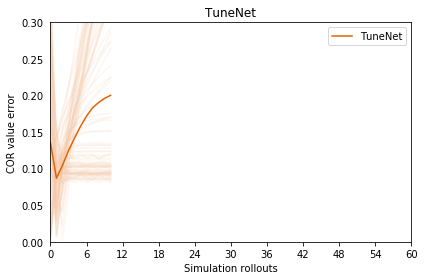

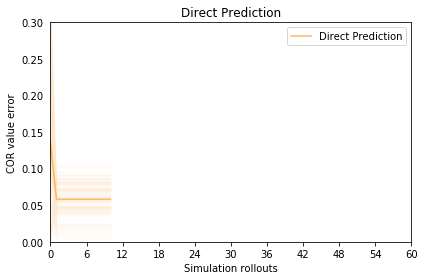

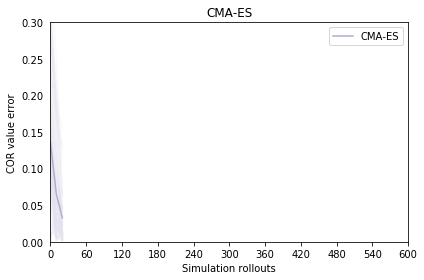

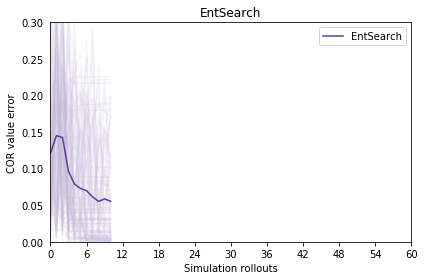

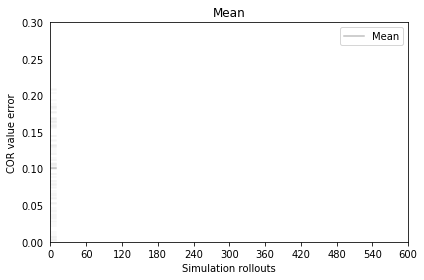

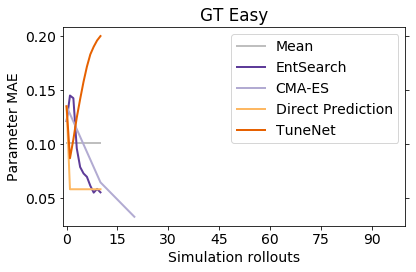

In [46]:
num_plots = 20
# cma_color = [1.0, 0.5, 0.0, 1.0]
# tunenet_color = [0.0, 0.0, 1.0, 1.0]
# tunenet_direct_color = [0.0, 0.7, 0.7, 1.0]
# entsearch_color = [0.0, 0.5, 0.0, 1.0]


tunenet_color = (np.array([230,97,1,255]) / 255).tolist()
tunenet_direct_color = (np.array([253,184,99,255]) / 255).tolist()
cma_color = (np.array([178,171,210,255]) / 255).tolist()
entsearch_color = (np.array([94,60,153,255]) / 255).tolist()
constant_color = [0.5, 0.5, 0.5, 0.5]

label_list = ["TuneNet",
              "Direct Prediction",
              "CMA-ES",
              "EntSearch",
              "Mean",
             ]
error_x_list = [np.asarray(list(range(len(mean_tunenet_error)))),
                np.asarray(list(range(len(mean_tunenet_direct_error)))),
                cma_evals[0],
                np.asarray(list(range(len(mean_entsearch_error)))),
                constant_x,
               ]
error_y_list = [mean_tunenet_error,
                mean_tunenet_direct_error,
                mean_cma_error,
                mean_entsearch_error,
                mean_constant_error,
               ]
error_each_list = [each_tunenet_error,
                   each_tunenet_direct_error,
                   each_cma_error,
                   each_entsearch_error,
                   each_constant_error,
                  ]
color_list = [tunenet_color, 
              tunenet_direct_color,
              cma_color,
              entsearch_color,
              constant_color,
             ]
        
# some quality of life functions
def lighten_value(val, amt):
    return val + (1-val)*amt

def faint(color, lighten=0.65, alpha=0.15):
    return [
        lighten_value(color[0], lighten),
        lighten_value(color[1], lighten),
        lighten_value(color[2], lighten),
        alpha
    ]

# Traces figure
for label, error_each, error_x, error_y, color in \
        zip(label_list, error_each_list, error_x_list, error_y_list, color_list):    
    fig, ax = plt.subplots()
    n_averaged = len(test_loader.dataset)
    for e in error_each:
        ax.plot(error_x, e, color=faint(color))
    ax.plot(error_x, np.mean(error_each, axis=0), color=color, label=label)
    
    ax.tick_params(
      axis='y',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      right=False,      # ticks along the bottom edge are off
      left=False,         # ticks along the top edge are off
      labelbottom=False) # labels along the bottom edge are off
    ax.get_xaxis().set_visible(True)
    ax.get_xaxis().set_visible(True)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("Simulation rollouts")
    ax.set_ylabel("COR value error")
    ax.set_xlim([0, 60*(error_x[1]-error_x[0])])
    ax.set_ylim([0, 0.3])
    ax.legend()
    ax.set_title(label)
    fig.tight_layout()
    filename = 'iterations_vs_performance_{}_{}.pdf'.format(prefix,
                                                            label.lower().replace('-', '').replace(' ', '_'))
    fig.savefig(os.path.join(ROOT_DIR, OUTPUT_DIR, prefix, filename))

    
# report the best value over this many iterations
min_over_iterations_list = [1, 5, 10, 100]
print("N = " + str(min_over_iterations_list))
print("minimum value over the first N iterations")
for label, error_each, x, error_y, color in \
        reversed(list(zip(label_list, error_each_list, error_x_list, error_y_list, color_list))):

    format_string = "{}"
    mins = []
    for n in min_over_iterations_list:
        up_thru_idx = 1
        for idx, xval in enumerate(x):
            if xval <= n and idx > up_thru_idx:
                up_thru_idx = idx
        print(up_thru_idx)
#         print(error_y)
#         mins.append(np.min(error_y[:up_thru_idx]))
        mins.append(error_y[up_thru_idx])
        format_string += " & {:.4f}"
    print(format_string.format((label + " "*20)[:20], *mins))

    
plt.rcParams.update({'font.size': 14})
# Combined figure
fig, ax = plt.subplots()
for label, error_each, error_x, error_y, color in \
        reversed(list(zip(label_list, error_each_list, error_x_list, error_y_list, color_list))):
    ax.plot(error_x, error_y, color=color, label=label, linewidth=2)

# base line
# ax.axhline(y=0, linestyle="--", color=[0.0, 0.0, 0.0, 0.5], label="target")
ax.tick_params(
  axis='y',          # changes apply to the x-axis
  which='both',      # both major and minor ticks are affected
  right=True,      # ticks along the bottom edge are off
  left=True,         # ticks along the top edge are off
  labelbottom=False) # labels along the bottom edge are off
ax.get_xaxis().set_visible(True)
ax.get_xaxis().set_visible(True)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Simulation rollouts")
ax.set_ylabel("Parameter MAE".format(n_averaged))
ax.set_xlim([-1, 100])
# ax.set_ylim([0, 0.15])
ax.legend()
ax.set_title(graph_title)

fig.tight_layout()
filename = 'error_vs_iterations_{}_all.pdf'.format(prefix)
fig.savefig(os.path.join(ROOT_DIR, OUTPUT_DIR, prefix, filename))

In [47]:
def midpoint_integration(x, y):
    """
    Calculate area under a curve using midpoint summation.
    :param x: vector of x-values
    :param y: vector of y-values
    """
    total = 0
    for i in range(len(x)-1):
        total += ((y[i+1] - y[i])/2 + y[i])*(x[i+1] - x[i])
    return total

# some quick tests
print(midpoint_integration([1, 2, 3], [1, 1, 1])) # rectangle, should = 2
print(midpoint_integration([1, 2, 3], [4, 0, 4])) # two triangles, should = 4
# complex, should = 23.5
print(midpoint_integration([0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 100], [3, 3, 1, 1, 4, 1, 2, 2, 4, 1, 0, 0]))

2.0
4.0
23.5


Area under the error curve, which is averaged over 100 datapoints, 1 run per datapoint, N simulations/run
N = 1 simulations:
  TuneNet:           0.111
  Direct Prediction: 0.097
  <skipping CMA-ES, cannot find data for exactly N=1 simulations>
  EntSearch:         0.133
  <skipping Mean, cannot find data for exactly N=1 simulations>

N = 2 simulations:
  TuneNet:           0.207
  Direct Prediction: 0.155
  <skipping CMA-ES, cannot find data for exactly N=2 simulations>
  EntSearch:         0.277
  <skipping Mean, cannot find data for exactly N=2 simulations>

N = 3 simulations:
  TuneNet:           0.321
  Direct Prediction: 0.213
  <skipping CMA-ES, cannot find data for exactly N=3 simulations>
  EntSearch:         0.397
  <skipping Mean, cannot find data for exactly N=3 simulations>

N = 5 simulations:
  TuneNet:           0.604
  Direct Prediction: 0.330
  <skipping CMA-ES, cannot find data for exactly N=5 simulations>
  EntSearch:         0.560
  <skipping Mean, cannot find data 

IndexError: index 0 is out of bounds for axis 0 with size 0

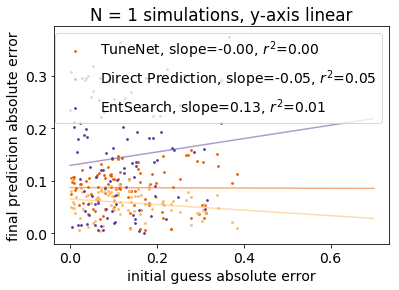

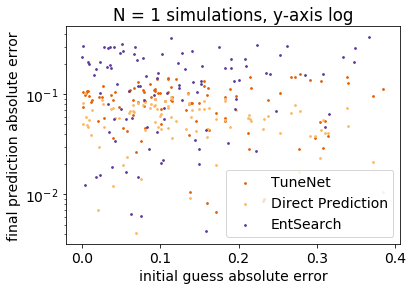

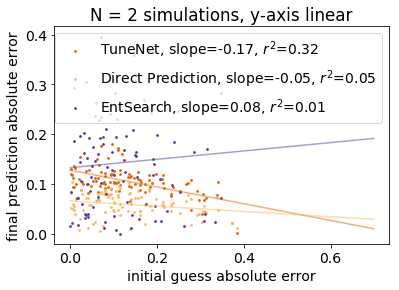

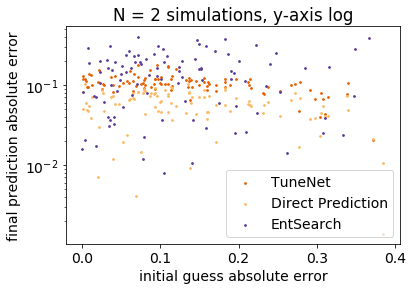

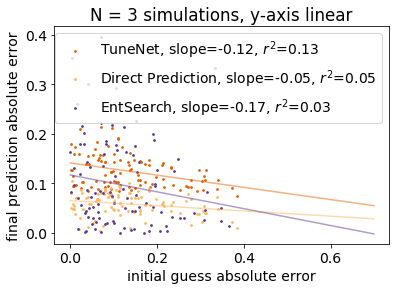

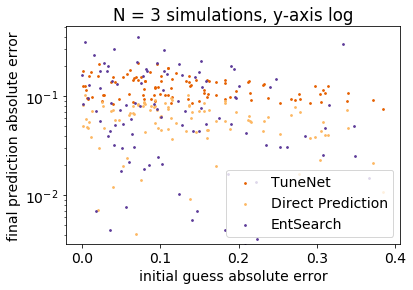

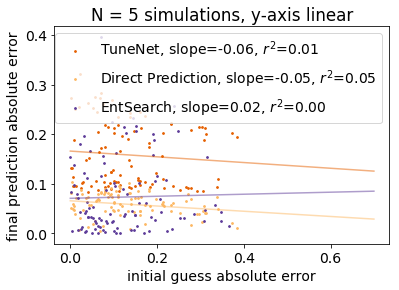

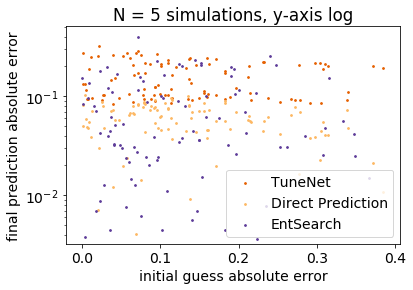

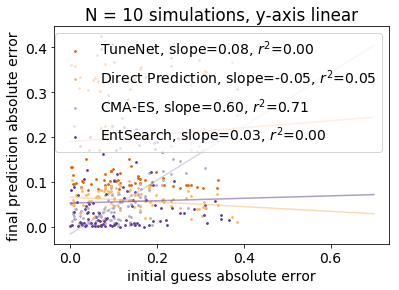

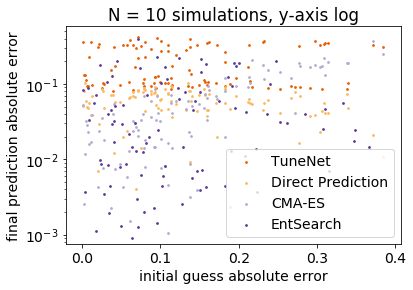

In [48]:
from numpy.polynomial.polynomial import polyfit
import scipy.stats

print("Area under the error curve, which is averaged over 100 datapoints, 1 run per datapoint, N simulations/run")

error = {}
padlen = max([len(l) for l in label_list]) + 4
for n in [1, 2, 3, 5, 10, 20, 100]:
    print("N = {} simulations:".format(n))
    _, ax_lin = plt.subplots()
    _, ax_log = plt.subplots()
    for typ, x, y, each_y, color in zip(label_list, error_x_list, error_y_list, error_each_list, color_list):
        if n not in x:
            print("  <skipping {}, cannot find data for exactly N={} simulations>".format(typ, n))
            continue
        up_thru_idx = np.where(x==n)[0][0]+1
        label_part = "  {}:".format(typ) + ' '*padlen
        print(label_part[:padlen] + 
              "{:.3f}".format(midpoint_integration(x[:up_thru_idx], y[:up_thru_idx])))
        if typ not in error:
            error[typ] = {'err_initial': {}, 'err_final': {}}
        error[typ]['err_initial'] = each_y[:, 0]
        error[typ]['err_final'][n] = each_y[:, up_thru_idx-1]
#         print(error[typ]['err_initial'].shape)
        
        ax_lin.set_title("N = {} simulations, y-axis linear".format(n))
        slope, intercept, r_value, p_value, std_err = \
            scipy.stats.linregress(error[typ]['err_initial'], error[typ]['err_final'][n])
        endpoints = np.array([0, 0.7])
        ax_lin.plot(endpoints, slope * endpoints + intercept, '-', color=faint(color, alpha=0.5, lighten=0.0))
        fit_label = ", slope={:.2f}, $r^2$={:.2f}".format(slope, r_value**2)
        
        ax_log.set_title("N = {} simulations, y-axis log".format(n))
        ax_log.set_yscale('log')
        
        for ax, label_suffix in zip([ax_lin, ax_log], [fit_label, ""]):
            ax.scatter(error[typ]['err_initial'], error[typ]['err_final'][n], label=typ + label_suffix, color=color, s=3)
            ax.legend()
            ax.set_xlabel("initial guess absolute error")
            ax.set_ylabel("final prediction absolute error")
    print("")
            
    # calculate mean and standard deviation of error across population

    

In [ ]:
# %%notify
pass